In [1]:
from deepforest import deepforest
from matplotlib import pyplot as plt
from deepforest import utilities
from deepforest import preprocess
import glob
import pandas as pd
import cv2
import numpy as np
import os
import comet_ml

Using TensorFlow backend.


# Goal

The aim of this notebook is to explore retraining deepforest on a small number of bird images in the everglades project.

In [2]:
model = deepforest.deepforest()
model.use_release()

Reading config file: /Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/deepforest/data/deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.2.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.2.1

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Just for fun, trees!

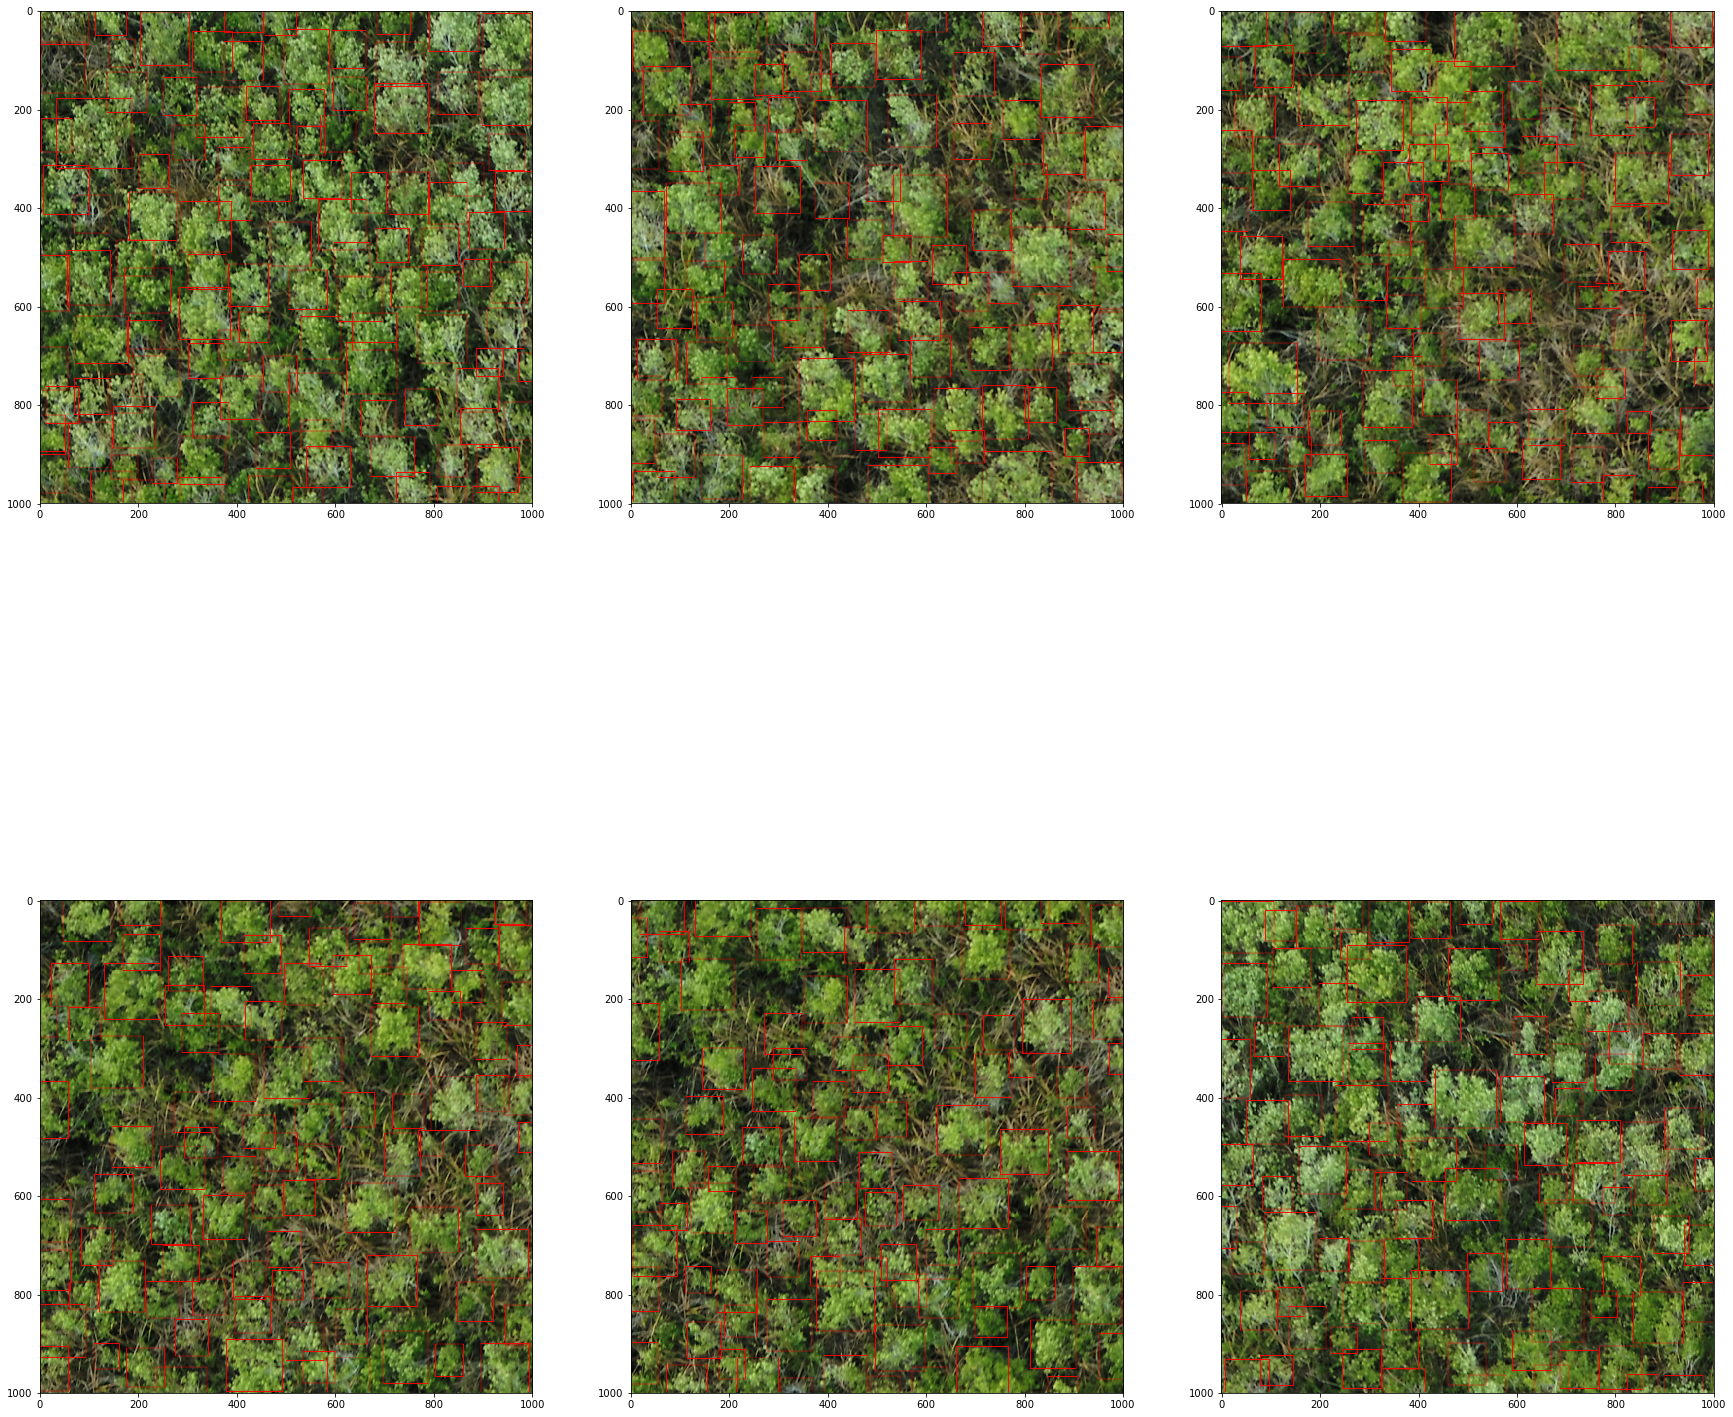

In [3]:
raster_path = "drone/DJI_0160.JPG"
numpy_image = cv2.imread(raster_path)
windows = preprocess.compute_windows(numpy_image, patch_size=1000,patch_overlap=0.05)
fig, axes, = plt.subplots(nrows=2,ncols=3, figsize=(30,30))
axes = axes.flatten()
for index in range(6):
    crop = numpy_image[windows[index].indices()] 
    #predict in bgr channel order
    prediction = model.predict_image(raw_image = crop[...,::-1],return_plot=True, score_threshold=0.05, color = (255,0,0))
    #but plot in rgb channel order
    axes[index].imshow(prediction)

## Format bird annotations

In [4]:
#convert hand annotations from xml into retinanet format
xmls = glob.glob("drone/*.xml")
annotation = []
for xml in xmls:
    parse = utilities.xml_to_annotations(xml)
    annotation.append(parse)

annotation = pd.concat(annotation)
#Write converted dataframe to file. Saved alongside the images
annotation.to_csv("output/drone_example.csv", index=False)

#Find image data on path and split into windows
images = glob.glob("drone/*.JPG")

window_annotations = []
for i in images:
    proccessed_annotations = preprocess.split_raster(path_to_raster=i,
                                     annotations_file="output/drone_example.csv",
                                     patch_size=400,
                                     base_dir = "output/",
                                     patch_overlap=0,
                                     allow_empty=True)
    window_annotations.append(proccessed_annotations)
    
window_annotations = pd.concat(window_annotations)

#Split into training and (tiny) test, allow for some empty windows
empty_annotations = window_annotations[window_annotations.label == ""] 
non_empty_annotations = window_annotations[~(window_annotations.label == "")] 

train_image_paths = pd.Series(non_empty_annotations.image_path.unique()).sample(frac=0.8)
train_annotations = non_empty_annotations[non_empty_annotations.image_path.isin(train_image_paths)]
test_annotations =  non_empty_annotations[~(non_empty_annotations.image_path.isin(train_image_paths))]

In [5]:
#add back in some empty windows and combine
test_empty_annotations = empty_annotations[~(empty_annotations.image_path.isin(test_annotations.image_path.unique()))].sample(n=10)
train_empty_annotations = empty_annotations[empty_annotations.image_path.isin(test_empty_annotations.image_path.unique())].sample(n=10)
train_annotations = pd.concat([train_annotations, train_empty_annotations])
test_annotations = pd.concat([test_annotations, test_empty_annotations])

#View output
train_annotations.head()

#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations_path = "output/train.csv"
train_annotations.to_csv(train_annotations_path,index=False, header=None)

test_annotations_path = "output/test.csv"
test_annotations.to_csv(test_annotations_path,index=False, header=None)

In [6]:
model.config["validation_annotations"] = "output/test.csv"
model.config["epochs"] = 4
model.config["save_path"] = "output/"

In [7]:
model.train(train_annotations_path)

There are 2 unique labels: ['Bird', 'Gator'] 
Disabling snapshot saving
Training retinanet with the following args ['--weights', '/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/deepforest/data/NEON.h5', '--backbone', 'resnet50', '--image-min-side', '800', '--multi-gpu', '1', '--epochs', '4', '--steps', '109', '--batch-size', '1', '--tensorboard-dir', 'None', '--workers', '1', '--max-queue-size', '10', '--freeze-layers', '0', '--score-threshold', '0.05', '--save-path', 'output/', '--snapshot-path', 'snapshots/', '--no-snapshots', 'csv', 'output/train.csv', 'output/classes.csv', '--val-annotations', 'output/test.csv']
Creating model, this may take a second...


/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 18) vs (9, 256, 3, 3)).
  weight_values[i].shape))
/Users/ben/miniconda3/envs/crowns/lib/python3.7/site-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((18,) vs (9,)).
  weight_values[i].shape))


tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)        

Epoch 1/4
109/109 [==============================] - 775s 7s/step - loss: 2.6328 - regression_loss: 1.6960 - classification_loss: 0.9368


Running network: 100% (35 of 35) |#######| Elapsed Time: 0:01:00 Time:  0:01:00
Parsing annotations: 100% (35 of 35) |###| Elapsed Time: 0:00:00 Time:  0:00:00


26 instances of class Bird with average precision: 0.0000
0 instances of class Gator with average precision: 0.0000
mAP: 0.0000
Epoch 2/4
109/109 [==============================] - 768s 7s/step - loss: 2.1921 - regression_loss: 1.3423 - classification_loss: 0.8498


Running network: 100% (35 of 35) |#######| Elapsed Time: 0:00:59 Time:  0:00:59
Parsing annotations: 100% (35 of 35) |###| Elapsed Time: 0:00:00 Time:  0:00:00


26 instances of class Bird with average precision: 0.5769
0 instances of class Gator with average precision: 0.0000
mAP: 0.5769
Epoch 3/4
109/109 [==============================] - 833s 8s/step - loss: 1.5642 - regression_loss: 1.2246 - classification_loss: 0.3396


Running network: 100% (35 of 35) |#######| Elapsed Time: 0:01:05 Time:  0:01:05
Parsing annotations: 100% (35 of 35) |###| Elapsed Time: 0:00:00 Time:  0:00:00


26 instances of class Bird with average precision: 0.6409
0 instances of class Gator with average precision: 0.0000
mAP: 0.6409
Epoch 4/4
109/109 [==============================] - 795s 7s/step - loss: 1.4188 - regression_loss: 1.1261 - classification_loss: 0.2927


Running network: 100% (35 of 35) |#######| Elapsed Time: 0:01:05 Time:  0:01:05
Parsing annotations: 100% (35 of 35) |###| Elapsed Time: 0:00:00 Time:  0:00:00


26 instances of class Bird with average precision: 0.6710
0 instances of class Gator with average precision: 0.0000
mAP: 0.6710


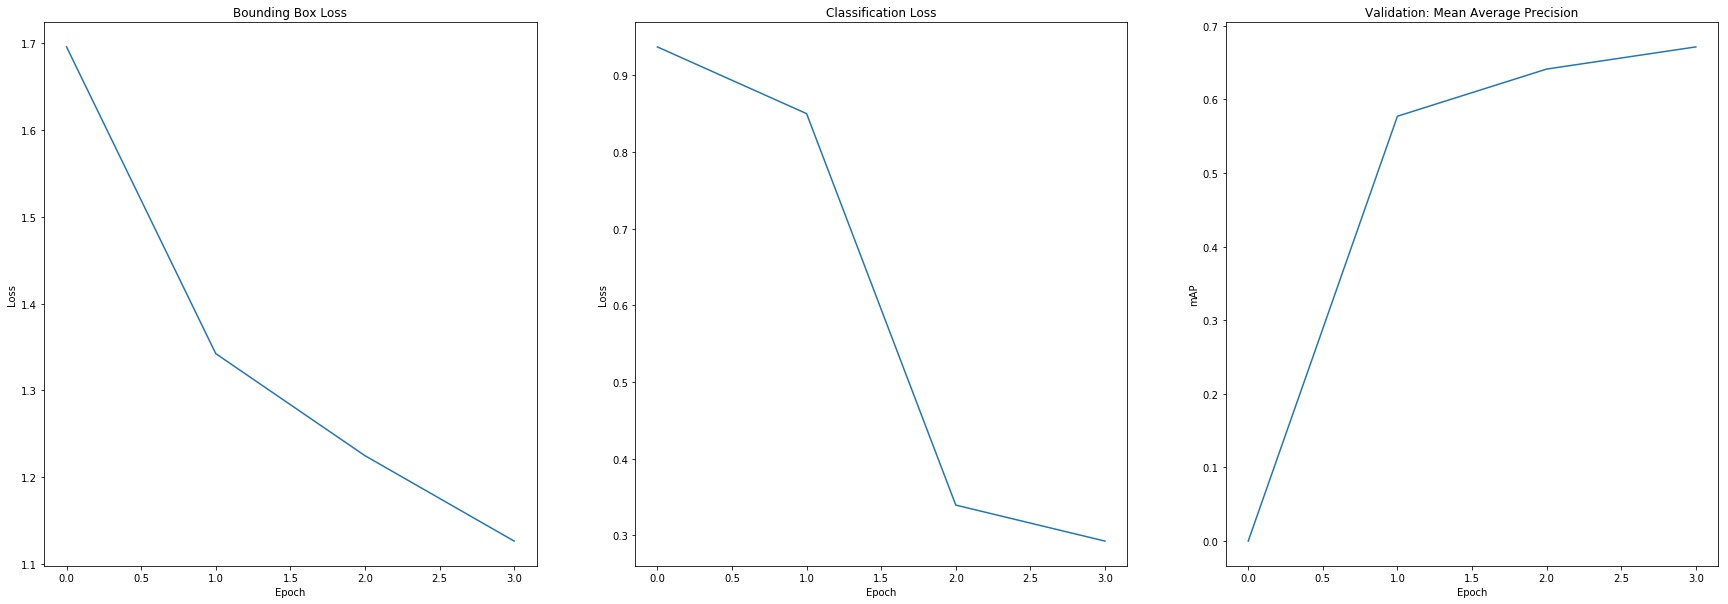

In [8]:
# Plot training & validation regression loss values
fig, axes, = plt.subplots(nrows=1,ncols=3,figsize=(30,10))
axes = axes.flatten()

#Regression Loss
axes[0].plot(model.model.history.history['regression_loss'])
axes[0].set_title('Bounding Box Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')

#Classification Loss        
axes[1].plot(model.model.history.history['classification_loss'])
axes[1].set_title('Classification Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

# Plot validation mAP
if "mAP" in model.model.history.history.keys():
    axes[2].plot(model.model.history.history['mAP'])
    axes[2].set_title('Validation: Mean Average Precision')
    axes[2].set_ylabel('mAP')
    axes[2].set_xlabel('Epoch')

In [9]:
model.evaluate_generator(test_annotations_path)

Running network: N/A% (0 of 35) |        | Elapsed Time: 0:00:00 ETA:  --:--:--

There are 1 unique labels: ['Bird'] 
Disabling snapshot saving


Running network: 100% (35 of 35) |#######| Elapsed Time: 0:01:14 Time:  0:01:14
Parsing annotations: 100% (35 of 35) |###| Elapsed Time: 0:00:00 Time:  0:00:00


26 instances of class Bird with average precision: 0.6710
mAP using the weighted average of precisions among classes: 0.6710
mAP: 0.6710


0.6710407239819005

In [10]:
fixed_winged_data = "/Users/ben/Dropbox/Everglades/Zooniverse/fixed_winged_data/IMG_2287.JPG"

In [12]:
prediction = model.predict_tile(fixed_winged_data,patch_overlap=0,patch_size=400, return_plot=True)

144 predictions in overlapping windows, applying non-max supression
138 predictions kept after non-max suppression


True

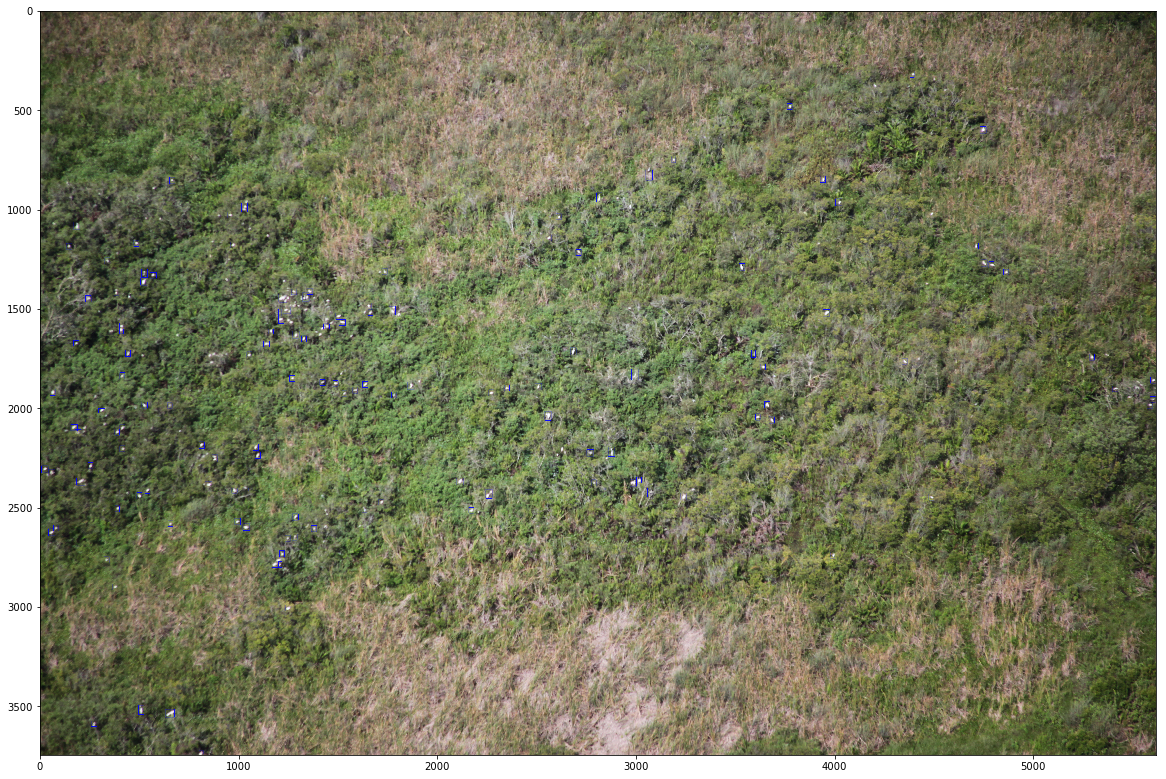

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(prediction)
cv2.imwrite("output/IMG_2287.JPG",prediction[:,:,::-1])